In [103]:
from pandas import read_csv
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K

In [104]:
#load and process data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('data.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
print("||"*40)
dataset.to_csv('pollution.csv')

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


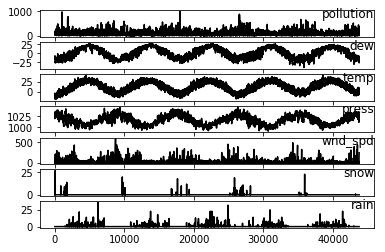

In [105]:
#generating dataset plot
from pandas import read_csv
from matplotlib import pyplot
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group],'k')
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [106]:
# Lets normalize all features, and remove the weather variables for the hour to be predicted.
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def s_to_super(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [107]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
encoder = preprocessing.LabelEncoder()
print(values[2])
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
print(values[2])
scaler = MinMaxScaler(feature_range=(0, 1))
print(scaler)
scaled = scaler.fit_transform(values)
print(scaled[2])
reframed = s_to_super(scaled, 1, 1)
print(reframed.head(5))

[159.0 -11 -5.0 1021.0 'SE' 3.57 0 0]
[ 159.    -11.     -5.   1021.      2.      3.57    0.      0.  ]
MinMaxScaler(copy=True, feature_range=(0, 1))
[0.15995975 0.4264706  0.22950819 0.545454   0.6666667  0.00533197
 0.         0.        ]
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
1   0.000000        0.0  0.148893  0.367647  0.245902  0.527273  0.666667   
2   0.000000        0.0  0.159960  0.426471  0.229508  0.545454  0.666667   
3   0.000000        0.0  0.182093  0.485294  0.229508  0.563637  0.666667   
4   0.037037        0.0 

In [108]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head(5))
print("** NOT REQUIRED DATA COLUMNS DROPPED **")
print("||"*40)
# split data into training and testing, futher splitting the train and test sets into i/p and o/p variables
# reshaped data further into 3D formate expected by LSTMs
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("** DATA SPLITTING COMPLETED **")
print(" Training data shape X, y => ",train_X.shape, train_y.shape," Testing data shape X, y => ", test_X.shape, test_y.shape)
print("||"*40)

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
** NOT REQUIRED DATA COLUMNS DROPPED **
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA SPLITTING COMPLETED **
 Training data shape X, y =>  (8760, 1, 8) (8760,)  Testing data shape X, y =>  (35039, 1, 8) (35039,)
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


Train on 8760 samples, validate on 35039 samples
Epoch 1/5
 - 2s - loss: 0.2997 - val_loss: 0.1380
Epoch 2/5
 - 1s - loss: 0.0947 - val_loss: 0.0749
Epoch 3/5
 - 1s - loss: 0.0762 - val_loss: 0.0710
Epoch 4/5
 - 1s - loss: 0.0725 - val_loss: 0.0684
Epoch 5/5
 - 1s - loss: 0.0692 - val_loss: 0.0656


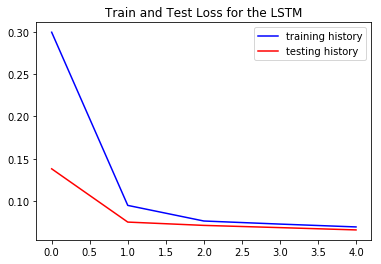

In [109]:
# defining LSTM with 50 neurons in first hidden layer and 1 neuron in the o/p layer
# using the MAE loss function and Adma version of stochastic gradient descent
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

#print(train_X[:5])

model = Sequential()
# 50 neurons in first hidden layer
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1,kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=5, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# tracking history for plots
pyplot.plot(history.history['loss'], 'b', label='training history')
pyplot.plot(history.history['val_loss'],  'r',label='testing history')
pyplot.title("Train and Test Loss for the LSTM")
pyplot.legend()
pyplot.show()

In [113]:
# evaluating model
# make a prediction
from math import sqrt
from numpy import concatenate

print(test_X[:2])
yhat = model.predict(test_X)
#print(yhat[:1])
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print(test_X[:2])
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

[[0.0362173  0.33823532 0.1967213  0.83636475 0.33333334 0.12757413
  0.         0.        ]
 [0.03118712 0.33823532 0.1967213  0.83636475 0.         0.006101
  0.         0.        ]]


ValueError: Error when checking : expected lstm_9_input to have 3 dimensions, but got array with shape (35039, 8)

In [1]:
import pandas as pd
import os
from pandas import read_csv
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K

d:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#load and process data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('week1_1.csv', index_col=0)
dataset.columns = ['week','p']
dataset.index.name = 'num'
dataset['week'].fillna(0, inplace=True)
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
dataset.to_csv('RTS.csv')

In [2]:
# load and process data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

os.chdir('D:/成功大學/课程/即時系統/RTS_LSTM')
file_chdir = os.getcwd()

filecsv_list=[]
for root, dirs, files in os.walk(file_chdir):
    for file in files:
        if os.path.splitext(file)[1] == '.csv':
            filecsv_list.append(file)
dataset = pd.DataFrame()
for csv in filecsv_list:#header=0,sep=None,
    dataset= dataset.append(pd.read_csv(csv,header=None,index_col=False, encoding='utf8',engine="python"))

#for i in range(1, 2, 1):
#    readset = read_csv('week'+str(i)+'_1.csv', index_col=0)
#    print('week'+str(i)+'_1.csv')
#    print(readset.head(5))
#    dataset.append(readset)
#dataset.columns = ['week','p']
#dataset.index.name = 'num'
#dataset['week'].fillna(0, inplace=True)
    
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
dataset.to_csv('RTS.csv')

** DATA PROCESSING COMPLETED **
   0  1
0  6  0
1  6  0
2  6  0
3  6  0
4  6  0


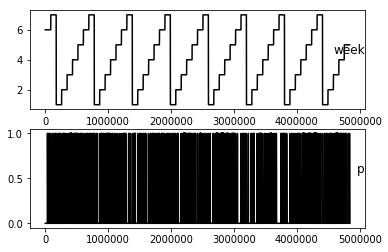

In [3]:
# generating dataset plot
from pandas import read_csv
from matplotlib import pyplot

dataset = read_csv('RTS.csv', header=0, index_col=0)
values = dataset.values
groups = [0, 1]
i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group],'k')
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [4]:
# Lets normalize all features, and remove the weather variables for the hour to be predicted.
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

def s_to_super(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
# load dataset
dataset = read_csv('RTS.csv', header=0, index_col=0)
values = dataset.values
encoder = preprocessing.LabelEncoder()
print(values[2])
values[:,1] = encoder.fit_transform(values[:,1])
values = values.astype('float32')
print(values[2])
scaler = MinMaxScaler(feature_range=(0, 1))
print(scaler)
scaled = scaler.fit_transform(values)
print(scaled[2])
reframed = s_to_super(scaled, 1, 1)
print(reframed.head(5))
print(reframed.shape)

[6 0]
[6. 0.]
MinMaxScaler(copy=True, feature_range=(0, 1))
[0.8333333 0.       ]
   var1(t-1)  var2(t-1)   var1(t)  var2(t)
1   0.833333        0.0  0.833333      0.0
2   0.833333        0.0  0.833333      0.0
3   0.833333        0.0  0.833333      0.0
4   0.833333        0.0  0.833333      0.0
5   0.833333        0.0  0.833333      0.0
(4838399, 4)


#drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print("** NOT REQUIRED DATA COLUMNS DROPPED**")
print("||"*40)
#split data into training and testing, futher splitting the train and test sets into i/p and o/p variables
#reshaped data further into 3D formate expected by LSTMs
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
#split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("** DATA SPLITTING COMPLETED**")
print(" Training data shape X, y => ",train_X.shape, train_y.shape," Testing data shape X, y => ", test_X.shape, test_y.shape)
print("||"*40)

In [6]:
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print("** NOT REQUIRED DATA COLUMNS DROPPED **")
print("||"*40)
# split data into training and testing, futher splitting the train and test sets into i/p and o/p variables
# reshaped data further into 3D formate expected by LSTMs
values = reframed.values
n_train_hours = 4233600
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("** DATA SPLITTING COMPLETED **")
print(" Training data shape X, y => ",train_X.shape, train_y.shape," Testing data shape X, y => ", test_X.shape, test_y.shape)
print("||"*40)

** NOT REQUIRED DATA COLUMNS DROPPED **
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA SPLITTING COMPLETED **
 Training data shape X, y =>  (4233600, 1, 3) (4233600,)  Testing data shape X, y =>  (604799, 1, 3) (604799,)
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [7]:
# defining LSTM with 50 neurons in first hidden layer and 1 neuron in the o/p layer
# using the MAE loss function and Adma version of stochastic gradient descent
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

print(train_X[:5])
print(train_y[:5])

[[[0.8333333 0.        0.8333333]]

 [[0.8333333 0.        0.8333333]]

 [[0.8333333 0.        0.8333333]]

 [[0.8333333 0.        0.8333333]]

 [[0.8333333 0.        0.8333333]]]
[0. 0. 0. 0. 0.]


Train on 4233600 samples, validate on 604799 samples
Epoch 1/10
 - 114s - loss: 0.0033 - val_loss: 6.9445e-04
Epoch 2/10
 - 110s - loss: 3.8454e-04 - val_loss: 6.9445e-04
Epoch 3/10
 - 111s - loss: 3.8454e-04 - val_loss: 6.9445e-04
Epoch 4/10
 - 112s - loss: 3.8454e-04 - val_loss: 6.9445e-04
Epoch 5/10
 - 123s - loss: 3.8454e-04 - val_loss: 6.9445e-04
Epoch 6/10
 - 112s - loss: 3.8454e-04 - val_loss: 6.9445e-04
Epoch 7/10
 - 113s - loss: 3.8454e-04 - val_loss: 6.9445e-04
Epoch 8/10
 - 112s - loss: 3.8454e-04 - val_loss: 6.9445e-04
Epoch 9/10
 - 111s - loss: 3.8454e-04 - val_loss: 6.9445e-04
Epoch 10/10
 - 111s - loss: 3.8454e-04 - val_loss: 6.9445e-04


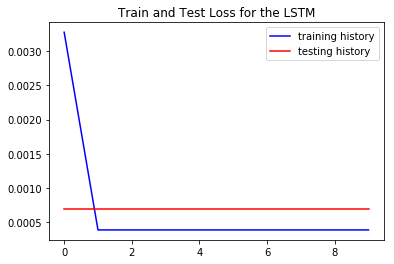

In [8]:
# defining LSTM with 50 neurons in first hidden layer and 1 neuron in the o/p layer
# using the MAE loss function and Adma version of stochastic gradient descent
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

#print(train_X[:5])

model = Sequential()
# 50 neurons in first hidden layer
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1,kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# tracking history for plots
pyplot.plot(history.history['loss'], 'b', label='training history')
pyplot.plot(history.history['val_loss'],  'r',label='testing history')
pyplot.title("Train and Test Loss for the LSTM")
pyplot.legend()
pyplot.show()

In [8]:
# evaluating model
# make a prediction
from math import sqrt
from numpy import concatenate
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (604799,3) (2,) (604799,3) 